In [1]:
# ---Libraires---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-05-01 13:47:22.996519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746107243.267193      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746107243.344610      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ---Load Data---

# ---dataset path---
image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"

SIZE = 1000

images_df = pd.read_csv(image_dataset_path + "train.csv")
images_df = images_df.drop(images_df.columns[0], axis=1)
images_df = images_df.rename(columns={images_df.columns[0]:'id'})
images_df['id'] = image_dataset_path + images_df['id']
images_df = images_df[:SIZE]

In [3]:
images_df.head()

,id,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


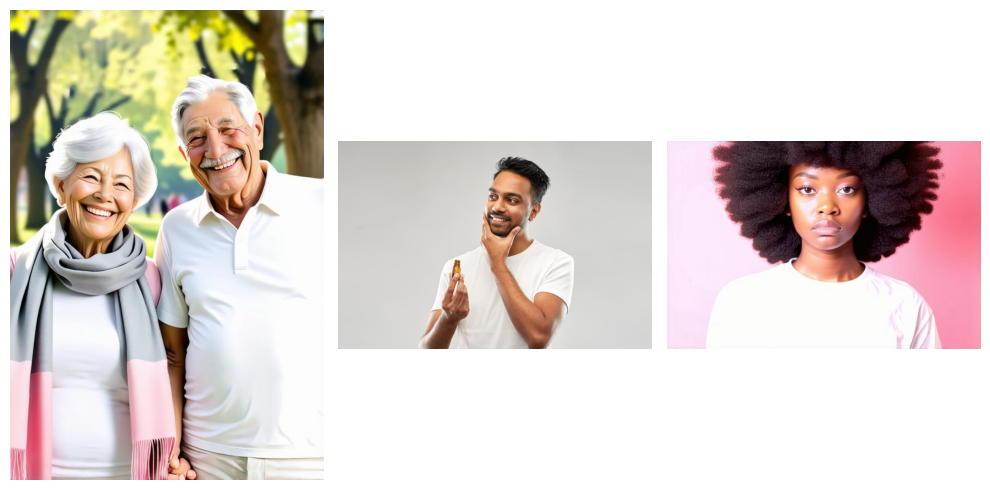

In [4]:
# View images
n_images = 3 

# Set up a square grid
plt.figure(figsize=(10,10))

for i in range(n_images):
    img_path = os.path.join(image_dataset_path, 'train', images_df['id'].iloc[i*3])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
IMG_SIZE = (128, 128)

# --- Preprocessing function ---
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image.numpy()
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    image_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    image_resized = cv2.resize(image_eq, IMG_SIZE)
    image_normalized = image_resized / 255.0
    return image_normalized

In [6]:
# --- Train test split---

train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=42, shuffle=True)

print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

Training set size: 800
Testing set size: 200


In [7]:
# --- Load images and labels using preprocess_image ---
train_images = []
train_labels = []

for idx, row in train_df.iterrows():
    file_path = os.path.join(image_dataset_path, row["id"])
    img_data = preprocess_image(file_path)
    train_images.append(img_data)
    train_labels.append(row["label"])  # Assuming 'label' column exists

X_train = np.array(train_images)
y_train = np.array(train_labels)

# --- Encode labels into one-hot ---
num_classes = len(np.unique(y_train))
y_train_encoded = np.eye(num_classes)[y_train]  

# --- Further split train into train/validation sets ---
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

2025-05-01 13:47:40.450988: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# --- Build CNN Model ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# --- Compile the model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Show model summary ---
model.summary()

# --- EarlyStopping Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 593ms/step - accuracy: 0.4371 - loss: 1.0130 - val_accuracy: 0.5750 - val_loss: 0.6761
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step - accuracy: 0.4897 - loss: 0.6936 - val_accuracy: 0.6250 - val_loss: 0.6755
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - accuracy: 0.6040 - loss: 0.6763 - val_accuracy: 0.6125 - val_loss: 0.6491
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.6421 - loss: 0.6375 - val_accuracy: 0.5875 - val_loss: 0.6631
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - accuracy: 0.6703 - loss: 0.6046 - val_accuracy: 0.5875 - val_loss: 0.6716
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 584ms/step - accuracy: 0.6841 - loss: 0.6208 - val_accuracy: 0.6000 - val_loss: 0.6574
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - accuracy: 0.7423 - loss: 0.5621 - val_accuracy: 0.6500 - val_loss: 0.5997
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.7875 - loss: 0.5091 - val_accu

In [9]:
model.save('detection.h5')

In [10]:
# ---Final Training Accuracy---
final_training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_training_accuracy:.4f}")

# ---Final Validation Accuracy---
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

Final Training Accuracy: 0.7859
Final Validation Accuracy: 0.6625


In [11]:
# --- Preprocess Test Set ---
test_images = []
test_labels = []

for idx, row in test_df.iterrows():
    file_path = os.path.join(image_dataset_path, row["id"])
    img_data = preprocess_image(file_path)
    test_images.append(img_data)
    test_labels.append(row["label"])  # Assuming 'label' column exists

X_test = np.array(test_images)
y_test = np.array(test_labels)

# One-hot encode y_test
y_test_encoded = np.eye(num_classes)[y_test]

# --- Evaluate on Test Set ---
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7650


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


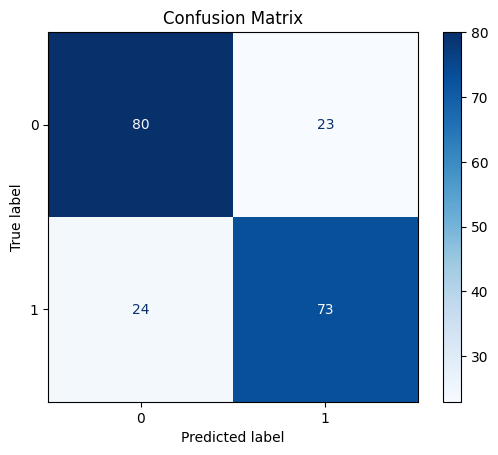

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import f1_score

# Assuming you already have y_true_classes and y_pred_classes from previous step
# Compute F1 score (macro, micro, or weighted based on your needs)

f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_micro = f1_score(y_true_classes, y_pred_classes, average='micro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")


F1 Score (Macro): 0.7647
F1 Score (Micro): 0.7650
F1 Score (Weighted): 0.7650


In [14]:
from sklearn.metrics import recall_score

# Compute Recall (macro, micro, or weighted based on your needs)
recall_macro = recall_score(y_true_classes, y_pred_classes, average='macro')
recall_micro = recall_score(y_true_classes, y_pred_classes, average='micro')
recall_weighted = recall_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Recall (Macro): {recall_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")

Recall (Macro): 0.7646
Recall (Micro): 0.7650
Recall (Weighted): 0.7650
